# Histopathologic Cancer Detection 
#### Aim: Create algorithm to identify metastatic cancer from small image patches taken from the larger digital pathology scans. 
#### These images are taken from the modified version of PathCamelon (PCam) benchmark dataset (duplicate entries have been removed, NB: duplicate entries existed owing to probabilistic sampling)

 Data description: Dataset contains large number of small pathology images to classify. Files are named with an image "id"
 The train_labels.csv file provides the ground truh for the images in the train folder. 
 We are predicting labels for the images in the test folder.
 A positive label indicates that the center 32x32px region of a patch contains atleast 1 pixel of tumor tissue. 
 Tumor tissue in the outer region of the patch does not influence the label. The outer region is provided to enable fully convolutional models which do not use padding to ensure consistend behaviour when applied to the whole slide. 
 
 
 Run the following cell to run all the packages and dependencies 

In [1]:
import numpy as np # linear algebra
import pandas as pd # dataprocessing
# import libraries
import zipfile # read ZIP file
import os # miscellaneous operating system interfaces
import json 
import shutil

from keras.preprocessing.image import ImageDataGenerator

# look at the data files
from subprocess import check_output

from glob import glob 


# import necessary packages
from imutils import paths #A series of convenience functions to 
# make basic image processing functions such as translation, 
# rotation, resizing, skeletonization, displaying Matplotlib 
# images, sorting contours, detecting edges, and much more easier
# with OpenCV and both Python 2.7 and Python 3.
import random # to generate psuedo random numbers
import os # operating systems interfaces 
import shutil # copy/remove on files and collection of files 
# (high-level file and directory handling)
import PIL

import matplotlib.pyplot as pyplot
from keras.preprocessing.image import load_img, img_to_array

# import function to split arrays into random train and test subsets 
from sklearn.model_selection import train_test_split

from keras.applications.resnet50 import ResNet50


from keras.models import Sequential

from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv2D, MaxPool2D

from keras.callbacks import EarlyStopping, ReduceLROnPlateau

%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Set path that you will use in this notebook 
root_dir = "/home/bithika/"

# notebook project directories
base_dir = root_dir + 'ml/Kaggle/pcam/'
!mkdir -p "{base_dir}"

Using TensorFlow backend.
/home/bithika/local/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/bithika/local/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/bithika/local/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])

In [2]:
(HEIGHT, WIDTH) = (224,224)# rescale images (higher performance; crop images)
(DEF_HEIGHT, DEF_WIDTH) = (96,96) # used for test data
# crop height and width = (def_height,def_width)
BATCH_SIZE = 32 

DROPOUT_RATE = 0.5

In [3]:
# set the random seed
np.random.seed(2)

In [4]:
import keras
keras.__version__

'2.2.4'

### Load data - old method

In [ ]:
# look at the data files
from subprocess import check_output
print(check_output(["ls", "/home/bithika/Dropbox/DL/Cancer_detection"]).decode("utf8"))

In [ ]:
# designate directory 
home_dir = "/home/bithika/Dropbox/DL/Cancer_detection/"
dataset = "histopathologic-cancer-detection"

In [ ]:
#unzip all the files 
zip_f = zipfile.ZipFile(home_dir+dataset+".zip")

In [ ]:
# this function allows you to extract source files into the 
# destination dictionary 
def unzip(source_filename, dest_dir):
    """Unzip
    
    Arguments: 
    source_filename -- full path of the source file to be unzipped
    dest_dir --  destination path where extracted file is saved
    
    """
    with zipfile.ZipFile(source_filename) as zf:
        zf.extractall(dest_dir)

In [ ]:
# Create target Directory if don't exist
dirName = "/home/bithika/Documents/DL/histopathologic-cancer-detection"
if not os.path.exists(dirName):
    os.mkdir(dirName)
    print("Directory " , dirName ,  " Created ")
else:    
    print("Directory " , dirName ,  " already exists")

In [ ]:
# unzip Datafiles downladed from Kaggle 
unzip(home_dir+Dataset+".zip",dirName)

In [ ]:
# list all the files with complete path in "dirName"
for dirname, _, filenames in os.walk(dirName):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
unzip("/home/bithika/Documents/DL/histopathologic-cancer-detection/train.zip",dirName)

In [ ]:
unzip("/home/bithika/Documents/DL/histopathologic-cancer-detection/test.zip",dirName)

In [ ]:
# DO NOT run this command as this exceeds the I/O data rate
# to avoid crashing the notebook server will stop it 
# list all the files with complete path in "dirName"
for dirname, _, filenames in os.walk(dirName):
    for filename in filenames:
        print(os.path.join(dirname, filename))

https://stackoverflow.com/questions/6996603/delete-a-file-or-folder

In [ ]:
# delete "histopathologic-cancer-detection" directory and all 
# its contents
import sys
import shutil

dirName = "/home/bithika/Documents/DL/histopathologic-cancer-detection"
if os.path.exists(dirName):
    shutil.rmtree(dirName)
    print("Directory " , dirName ,  " deleted ")
else:    
    print("Directory " , dirName ,  " deletion failed")

In [ ]:
# check if the directory has ben deleted
# no output means folder is empty
dirDelName = "/home/bithika/Documents/DL/"
from subprocess import check_output
print(check_output(["ls", dirDelName]).decode("utf8"))

### Using Kaggle API and SDK to download dataset 

The data we are using lives on Kaggle. We use Kaggle's API <sup>[1](#APIlaunch)</sup> for downloading datasets and later for submitting to competetions [2](#beta)</sup>. To used Kaggle API we need to first sign up for a Kaggle account at  https://www.kaggle.com/.  Once logged into Kaggle, navigate to "My Account" in the top right option of the menu bar. Then scroll down to where you can see "Create New API Token". This will download a JSON file to your computer with your username and token string. Copy these to ~/.kaggle/kaggle.json token file.

For your security, ensure that other users of your computer do not have read access to your credentials. On Unix-based systems you can do this with the following command:<br /> 
chmod 600 ~/.kaggle/kaggle.json

<a name="APIlaunch">1</a>: Kaggle API was launched in 2017.
<br /> 
<a name="beta">2</a>: Kaggle API is a Beta release.


PreReq:  Python 3

In [ ]:
# First we make sure that we have Kaggle sdk installed
# We assume that kaggle.json file is stored in at ~/.kaggle/kaggle.json
!pip install kaggle

In [ ]:
# Kaggle API version 
!kaggle --version

**Kaggle API: Download Competition Data**

In [ ]:
# Can list available Kaggle 
!kaggle datasets list

In [ ]:
!kaggle competitions download -c histopathologic-cancer-detection -p "{base_dir}" 

In [ ]:
# this function allows you to extract source files into the 
# destination dictionary 
def unzip(source_filename, dest_dir):
    """Unzip
    
    Arguments: 
    source_filename -- full path of the source file to be unzipped
    dest_dir --  destination path where extracted file is saved
    
    """
    with zipfile.ZipFile(source_filename) as zf:
        zf.extractall(dest_dir)

In [ ]:
#unzip data files
unzip('/home/bithika/ml/pcam/histopathologic-cancer-detection.zip',base_dir)

In [ ]:
# list files in base directory
from subprocess import check_output
print(check_output(["ls", base_dir]).decode("utf8"))

In [ ]:
# unzip training files
!mkdir -p "{base_dir}train/"
dest_dir_name = os.path.join(base_dir , 'train/') #concatenate path and filename
print(base_dir+'train.zip') # included to print dataset
train_zip = zipfile.ZipFile(base_dir+'train.zip','r')# read train.zip
train_zip.extractall(dest_dir_name)
train_zip.close()


In [ ]:
# remove train.zip
os.remove(base_dir+'train.zip')
print(check_output(["ls", base_dir]).decode("utf8"))

In [ ]:
# move train into VALTRAIN/oldtrain folder
dest_dir_name = os.path.join(base_dir , 'VALTRAIN/oldtrain')
source_dir_name = os.path.join(base_dir,'train')
shutil.move(source_dir_name,dest_dir_name)

In [ ]:
# unzip test files 
!mkdir -p "{base_dir}test/"
dest_dir_name = os.path.join(base_dir,'test/')#concatenate path
test_zip = zipfile.ZipFile(base_dir+'test.zip','r')#read test.zip
test_zip.extractall(dest_dir_name)
test_zip.close()

In [ ]:
print(check_output(["ls", base_dir]).decode("utf8"))

In [ ]:
# remove test.zip
os.remove(base_dir+'test.zip')
print(check_output(["ls", base_dir]).decode("utf8"))

In [ ]:
# Data preparation
# Data loading 

2.2 Check for null and missing values
2.3 Normalization
2.4 Reshape
2.5 Label encoding
2.6 Split training and valdiation set  - all done on 9th Oct

**Input data format**
The most common inpute parameters are:
1. Number of images
2. Image height
3. Image width
4. number of channels(usually 2 channels corresponding to RGB Pizel levels (0-255))

Preprocessing steps:
1. Uniform aspect ratio - Images have same size and aspect ratio (most NNs assume square input shape)
**Method**:Cropping - focus on center part of image
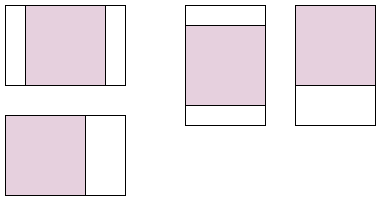

2. Image Scaling: upscaling and down scaling 


### How to Progressively Load Images
It is possible to write code to manually load image data and return data ready for modeling.

This would include walking the directory structure for a dataset, loading image data, and returning the input (pixel arrays) and output (class integer).

Thankfully, we don’t need to write this code. Instead, we can use the ImageDataGenerator class provided by Keras.

The main benefit of using this class to load the data is that images are loaded for a single dataset in batches, meaning that it can be used for loading both small datasets as well as very large image datasets with thousands or millions of images.

Instead of loading all images into memory, it will load just enough images into memory for the current and perhaps the next few mini-batches when training and evaluating a deep learning model. I refer to this as progressive loading, as the dataset is progressively loaded from file, retrieving just enough data for what is needed immediately.

Two additional benefits of the using the [ImageDataGenerator class](https://keras.io/preprocessing/image/) is that it can also automatically scale pixel values of images and it can automatically generate augmented versions of images. We will leave these topics for discussion in another tutorial and instead focus on how to use the ImageDataGenerator class to load image data from file.

The pattern for using the Image processing is used as follows:

1. Construct and configure an instance of the ImageDataGenerator class.
2. Retrieve an iterator by calling the flow_from_directory() function.
3. Use the iterator in the training or evaluation of a model.

Let’s take a closer look at each step

The constructor for the ImageDataGenerator contains many arguments to specify how to manipulate the image data after it is loaded, including pixel scaling and data augmentation. We do not need any of these features at this stage, so configuring the ImageDataGenerator is easy.

Next, an iterator is required to progressively load images for a single dataset.

This requires calling the flow_from_directory() function and specifying the dataset directory, such as the train, test, or validation directory.

The function also allows you to configure more details related to the loading of images. Of note is the ‘target_size‘ argument that allows you to load all images to a specific size, which is often required when modeling. The function defaults to square images with the size (256, 256).

The function also allows you to specify the type of classification task via the ‘class_mode‘ argument, specifically whether it is ‘binary‘ or a multi-class classification ‘categorical‘.

The default ‘batch_size‘ is 32, which means that 32 randomly selected images from across the classes in the dataset will be returned in each batch when training. Larger or smaller batches may be desired. You may also want to return batches in a deterministic order when evaluating a model, which you can do by setting ‘shuffle‘ to ‘False.’

There are many other options, and I encourage you to review the [API documentation.](https://keras.io/preprocessing/image/)

We can use the same ImageDataGenerator to prepare separate iterators for separate dataset directories. This is useful if we would like the same pixel scaling applied to multiple datasets (e.g. trian, test, etc.).

In [3]:
# initialize the path to the base path with contains train and test directorry
ORIG_INPUT_DATASET = "/home/bithika/ml/Kaggle/pcam"

# derive the training, validation, and testing directories
TRAIN_PATH = os.path.sep.join([ORIG_INPUT_DATASET, "training"])
VAL_PATH = os.path.sep.join([ORIG_INPUT_DATASET, "validation"])
VALTRAIN_PATH = os.path.sep.join([ORIG_INPUT_DATASET, "VALTRAIN"])
TEST_PATH = os.path.sep.join([ORIG_INPUT_DATASET, "TEST"])

In [4]:
print(check_output(["ls", base_dir]).decode("utf8"))

docs
notebooks
pseudocode.txt
sample_submission.csv
TEST
training
train_labels.csv
tree_after_data_split.png
validation
VALTRAIN



 we need to make a dataframe contanint the every training and validation example image's path, id and labels


In [11]:
# SAVE train_labels.csv as a dataframe
labels = pd.read_csv(os.path.join(ORIG_INPUT_DATASET,'train_labels.csv'))

In [12]:
# displaying only frist 10 entries in the labels dataframe
labels[:10] 

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0
5,acfe80838488fae3c89bd21ade75be5c34e66be7,0
6,a24ce148f6ffa7ef8eefb4efb12ebffe8dd700da,1
7,7f6ccae485af121e0b6ee733022e226ee6b0c65f,1
8,559e55a64c9ba828f700e948f6886f4cea919261,0
9,8eaaa7a400aa79d36c2440a4aa101cc14256cda4,0


In [13]:
# now we want to add filepath's to a dataframe which also contains id and label
# we use glob. Globbing is a technical term for matching files by name or type of file. 
# here we use it to match by file type. 

# we need to go into subfolders "oldtrain" inside the VAL_TRAIN_PATH - this should be created before we split data


In [14]:
# join the folder 
val_train_tif = os.path.join(VALTRAIN_PATH,"oldtrain")
val_train_tif

'/home/bithika/ml/Kaggle/pcam/VALTRAIN/oldtrain'

In [7]:
# using globbing to match all files with .tif file type and save in a dataframe
path_labels = pd.DataFrame({'path':glob(os.path.join(val_train_tif,'*.tif'))})

In [15]:
path_labels.head() # glance at the data# using globbing to match all files with .tif file type and save in a dataframe
path_labels = pd.DataFrame({'path':glob(os.path.join(val_train_tif,'*.tif'))})

In [16]:
# lambda function is a small anonymous function, which can take anny number of arguments but can have only one expredtssion
# lambda function can be used when we need to perform transformation or operation on
# pandas seriesor dataframe (it can also be used on lists in python )
# with a combination of map() method when applied to a series takes each element in the series and 
# applies a function to it and returns the transformed series

# we add another column labeled 'id'  to the path_labels dataframe
# it's value is just the file name of the tif file saved in a specific filepath 
path_labels['id'] = path_labels.path.map(lambda x : ((x.split('n/')[1].split('.')[0])))


In [17]:
# merge dataframes on label = 'id'
path_labels = path_labels.merge(labels, on='id')

Choose 6 random positive and negative examples, find their respective path and then display them in subplot

In [18]:
positive_indices = list(np.where(path_labels["label"] == True)[0])
negative_indices = list(np.where(path_labels["label"] == False)[0])

# take 3 random positive indices and negative indices
random_positive_indices = random.sample(positive_indices,3)
random_negative_indices = random.sample(negative_indices,3)

In [19]:
def img_load_array(path):
    """
    Convert loaded image to an numpy array
    
    Prereq: numpy, from keras_preprocessing.image import img_to_array, load_img
    
    Argument: path (dtype: string)
    
    Return:Image as an numpy array 
    """
    ## Read in the current image
    image_keras = load_img(path)
    # Convert image to numpy array
    image_array = img_to_array(image_keras)
    
    return image_array
    

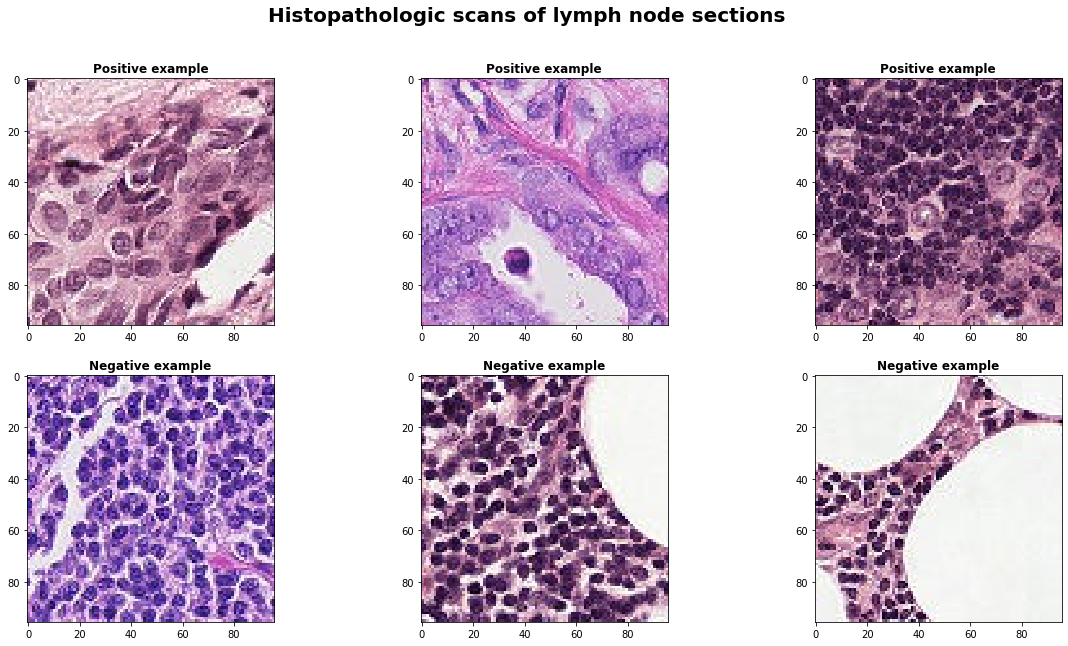

In [20]:


# instantiate 'Figure' class by 'fig'. Creates a '.Rectangle' instance representing a 
# figure patch 
# Add a subplot to with nrows = 2 and ncols = 3 and use figsize to make the figure bigger
# 20  by 10 inches
fig, ax = pyplot.subplots(2,3, figsize=(20,10)) # 2 rows and 3 columns

# Add a centered title to the figure.
fig.suptitle('Histopathologic scans of lymph node sections',fontsize=20, fontweight='bold')

for i in range(0,3):
    # Display image in first row and i'th column axes location - 1/255 ensures that RGB values are in range [0,1] for float values 
    ax[0,i].imshow(img_load_array(path_labels.iloc[random_positive_indices[i],0])/255)
    # Set a  centered title for the image diplayed at axes defined above 
    ax[0,i].set_title("Positive example", fontweight = 'bold')
    
    # Display image in first row and i'th column axes location - 1/255 ensures that RGB values are in range [0,1] for float values 
    ax[1,i].imshow(img_load_array(path_labels.iloc[random_negative_indices[i],0])/255)
    # Set a  centered title for the image diplayed at axes defined above 
    ax[1,i].set_title("Negative example", fontweight = 'bold')


### Data Split
Making good choices in how you set up your training, development, and test sets can make a huge difference in helping you quickly find a good high performance neural network.
We are given training (~80%) and test(~20%) data (following [Pareto's principle](https://en.wikipedia.org/wiki/Pareto_principle)). Its a good practice to carve off a portion of the training set to be the hold-out cross validation set and thi sis sometimes also called developtment test (dev set. Note that the test data is already given but all the data is coming from PCAM distribution only.  

On the rule of thumb for the ratios of train,dev and test datas to be taken <sup> [2](#trainvsdevvstest)</sup>. If you have maybe 100 examples in total, maybe 1000 examples in total, maybe after 10,000 examples. Conventionally several years ago a good practice was to take all your data and split it according to maybe a 70/30% in terms of a people often talk about the 70/30 train test splits. If you don't have an explicit dev set or maybe a 60/20/20% split in terms of 60% train, 20% dev and 20% test. In modern era of big data, if you have a million examples, you might end up with 99.5% train and 0.25% dev, 0.25% test. Or maybe a 0.4% dev, 0.1% test.

<a name="trainvsdevvstest"> 2</a>: [Is there a rule-of-thumb for how to divide a dataset into training and validation sets?](https://stackoverflow.com/questions/13610074/is-there-a-rule-of-thumb-for-how-to-divide-a-dataset-into-training-and-validatio)

config.py : A configuration file. I opted to use Python directly instead of YAML/JSON/XML/etc. This file is useful when working on larger deep learning projects. Here I store all my constant variable. (I have not made this file - to be included in future)

#### data shuffle

In [19]:



# grab the paths to all the input images in the TRAIN directory
# and shuffle them 
valtrainPaths = list(paths.list_images(VALTRAIN_PATH))
random.seed(42)
random.shuffle(valtrainPaths)


#### data split

##### short method

Classic way with ```train_test_split```

In [20]:
path_labels.head()

,path,id,label
0,/home/bithika/ml/Kaggle/pcam/VALTRAIN/oldtrain...,ed0be78e83ad27534917bffa41ec5cfbe0c9f536,0
1,/home/bithika/ml/Kaggle/pcam/VALTRAIN/oldtrain...,c0f6cadd16cad6c9e34b327a344ef38e198d858e,1
2,/home/bithika/ml/Kaggle/pcam/VALTRAIN/oldtrain...,bdae76041b6b2ab73aa204273a3bf429b55b5098,1
3,/home/bithika/ml/Kaggle/pcam/VALTRAIN/oldtrain...,ae9850e5e9fe2effa30db7b2f8bb608380170df5,0
4,/home/bithika/ml/Kaggle/pcam/VALTRAIN/oldtrain...,914f3ab2261c692ae2ae32cb05436f4ec737e6d3,0


In [21]:
TestPaths = list(paths.list_images(TEST_PATH)) # list files inside 
ValTrainPaths = list(paths.list_images(VALTRAIN_PATH)) # list files inside 
print("There are " + str(len(ValTrainPaths)) + " training examples.")
print("There are " + str(len(TestPaths)) + " test examples.")

There are 220025 training examples.
There are 57458 test examples.


Split 20% of training dataset into validation dataset


In [22]:
path_labels['label']= path_labels['label'].astype(str)  # cast label values as str dtype
TrainPaths, ValidPaths = train_test_split(path_labels, test_size = 0.2,random_state = 220, stratify = path_labels['label']) # split pandas
# dataframe 20% of valtrain data is saved as validation data using the random seed defined 
# above and stratified by 'labels' in panda dataframe


##### long method

In [ ]:
# the amount of validation data will be a percentage of the
# *training* data
VAL_SPLIT = .125

# we'll be using part of the training data for validation 

# compute the index of training/validation split
i = int(len(valtrainPaths)*VAL_SPLIT) 
# split image paths into valPaths and trainPaths
valPaths = valtrainPaths[:i]
trainPaths = valtrainPaths[i:]

testPaths = list(paths.list_images(TEST_PATH))

In [ ]:
print(len(trainPaths), len(valPaths), len(testPaths))
print(trainPaths[1],"\n", valPaths[1] ,"\n", testPaths[1])


define datasets that we'll be building 
Here I’ve created a list of 3-tuples (called datasets ) containing:

1. The name of the split
2. The image paths for the split
3. The path to the output directory for the split

In [ ]:
# define datasets that we'll be building 
datasets = [("training", trainPaths, TRAIN_PATH),
           ("validation", valPaths, VAL_PATH)
           ]

In [ ]:
# inspecting project structure
!tree --dirsfirst --filelimit 10

In [ ]:
# loop over the datasets
for (dType, valtrainPaths, baseOutput) in datasets:
	# show which data split we are creating
	print("[INFO] building '{}' split".format(dType))
 
	# if the output base output directory does not exist, create it
	if not os.path.exists(baseOutput):
		print("[INFO] 'creating {}' directory".format(baseOutput))
		os.makedirs(baseOutput)
 
	# loop over the input image paths
	for inputPath in valtrainPaths:
		# extract the filename of the input image along with its
		# corresponding class label
		filename = inputPath.split(os.path.sep)[-1]
		label = inputPath.split(os.path.sep)[-2]
 
		# build the path to the label directory
		labelPath = os.path.sep.join([baseOutput, label])
 
		# if the label output directory does not exist, create it
		if not os.path.exists(labelPath):
			print("[INFO] 'creating {}' directory".format(labelPath))
			os.makedirs(labelPath)
 
		# construct the path to the destination image and then copy
		# the image itself
		p = os.path.sep.join([labelPath, filename])
		shutil.copy2(inputPath, p)

In [ ]:
# determine the total number of image paths in training,validation
# and training data
totalTrain = len(list(paths.list_images(TRAIN_PATH)))
totalValid = len(list(paths.list_images(VAL_PATH)))
totalTest = len(list(paths.list_images(TEST_PATH)))
# We’ll need these quantity values to determine the total number of steps 
# per epoch for the validation/testing process.

In [ ]:
print("Train: ",totalTrain,"\n", "Valid: ",totalValid,"\n", \
      "Test: ",totalTest, "\n")

#### COMMENT ABOUT FILE PATH for Imagedatagenerator
I guess your path( "C:\Users\user\Downloads\Research\New folder") has the images.
You need to get those images and store it in a new folder inside the 'New Folder' so your path must look like - C:\Users\user\Downloads\Research\New folder\Sub_Dir_Containing_Images' . Then you must pass the same path again. Remember don't change the path!

validation_generator = test_datagen.flow_from_directory(
r'C:\Users\user\Downloads\Research\New folder', ## No change in the path
target_size=(28,28),
batch_size=32,
class_mode='binary')

Also for deep dive, one must remember that ImageDataGenerator.flow_from_directory was created keeping in mind the good ol' image classification problem. So flow_from_directory() receives a folder name where different folder resides containing the images(traversal of nested sub directories). What most people tend to do is directly pass the the folder which contains the images.

<font color=red> **Things to resolve** </font>
1. Image size needs to be 64x64 or 96x96 would work 
2. Image cropping etc - 
3. Resnet in keras uses imagenet for weights...
4. Understand how to implement transferlearning 

### Data Preprocessing - ignore code from here for modeling - text is useful
This is important because significant reduction in the NN prediction errors is possible by conducting appropriate input data transformations a.k.a data preprocessing<sup>[1](#Datapreprocessing)</sup>

<a name ="Datapreprocessing">1</a>: [Some methods of pre-processing input data
for neural networks](https://pdfs.semanticscholar.org/9052/2abb6613f083faf19ebc7d51a74a215cf344.pdf)



In [ ]:
# set the matplotlib backend so figures can be saved in the 
# background
%matplotlib inline
import matplotlib
#matplotlib.use("Agg")
 
# import the necessary packages
    # keras is being use to train deep learning model

from keras.callbacks import LearningRateScheduler
from keras.optimizers import SGD
    # sklearn is used to print classification_report
from sklearn.metrics import classification_report
    # grab paths from dataset 
from imutils import paths #needs opencv-python
from matplotlib import pyplot as pltt
import numpy as np # for numerical processing
import argparse # for command line argument parsing.
import csv
import cv2


# construct the argument parser and parse the arguments
ap = argparse.ArgumentParser()
ap.add_argument("-p", "--plot", type=strfrom keras.preprocessing.image import ImageDataGenerator, default="plot.png", help="path to output loss/accuracy plot")
#args = vars(ap.parse_args())

In [ ]:
# define the total number of epochs to train for along with the
# initial learning rate and batch size
NUM_EPOCHS = 50 # training iterations
INIT_LR = 1e-1 # initial learning rate
Batch_Size = 32 # batch size of 32 is good for CPUs, take 64 for GPUs

# This function will help us decay our learning rate after each 
# epoch. We’re setting power = 1.0  which effectively turns our
# polynomial decay into a linear decay.
def poly_decay(epoch):
	# initialize the maximum number of epochs, base learning rate,
	# and power of the polynomial
	maxEpochs = NUM_EPOCHS
	baseLR = INIT_LR
	power = 1.0
 
	# compute the new learning rate based on polynomial decay
	alpha = baseLR * (1 - (epoch / float(maxEpochs))) ** power
 
	# return the new learning rate
	return alpha

In [ ]:
# determine the total number of image paths in training,validation
# and training data
totalTrain = len(list(paths.list_images(TRAIN_PATH)))
totalValid = len(list(paths.list_images(VAL_PATH)))
totalTest = len(list(paths.list_images(TEST_PATH)))
# We’ll need these quantity values to determine the total number of steps 
# per epoch for the validation/testing process.

In [ ]:
print("Train: ",totalTrain,"\n", "Valid: ",totalValid,"\n", \
      "Test: ",totalTest, "\n")

In [ ]:
import csv
label_count = sum(1 for row in csv.reader(open('/home/bithika/ml/pcam/train_labels.csv')))-1

In [ ]:
print(label_count)

In [ ]:
# printing pixel, format of an image file from train data
from keras.preprocessing.image import load_img
# load the image
img = load_img(trainPaths[5])
# report details about the image
print(type(img))
print(img.format)# TIFF
print(img.mode)# RGB
print(img.size) #96x96
# show the image
# img.show()
# we can confirm that image loaded as a PIL (Python Image Library) image in Tiff format
# with RGB channels and size of 96 x 96 pixels

In [ ]:
trainPaths[5]

In [ ]:
# convert the image to numpy array
from keras_preprocessing.image import img_to_array
img_array = img_to_array(img)
print(img_array.dtype)
print(img_array.shape)

In [ ]:
# convert the numpy array back to image
from keras_preprocessing.image import array_to_img
img_pil = array_to_img(img_array)
print(type(img_pil))


### Image data augmentation- ignore code from here for modeling - text is useful
The performance of deep learning neural networks often improves with the amount of data available.

Data augmentation is a technique to artificially create new training data from existing training data. This is done by applying domain-specific techniques to examples from the training data that create new and different training examples. Augmentation here does not refer to increasing the number of (totally distinct) training samples. Rather, it is the process of creating different variations of existing training samples

Image data augmentation is perhaps the most well-known type of data augmentation and involves creating transformed versions of images in the training dataset that belong to the same class as the original image.

Transforms include a range of operations from the field of image manipulation, such as shifts, flips, zooms, and much more.

The intent is to expand the training dataset with new, plausible examples. This means, variations of the training set images that are likely to be seen by the model. For example, a horizontal flip of a picture of a cat may make sense, because the photo could have been taken from the left or right. A vertical flip of the photo of a cat does not make sense and would probably not be appropriate given that the model is very unlikely to see a photo of an upside down cat.

As such, it is clear that the choice of the specific data augmentation techniques used for a training dataset must be chosen carefully and within the context of the training dataset and knowledge of the problem domain. In addition, it can be useful to experiment with data augmentation methods in isolation and in concert to see if they result in a measurable improvement to model performance, perhaps with a small prototype dataset, model, and training run.

Modern deep learning algorithms, such as the convolutional neural network, or CNN, can learn features that are invariant to their location in the image. Nevertheless, augmentation can further aid in this transform invariant approach to learning and can aid the model in learning features that are also invariant to transforms such as left-to-right to top-to-bottom ordering, light levels in photographs, and more.

Image data augmentation is typically only applied to the training dataset, and not to the validation or test dataset. This is different from data preparation such as image resizing and pixel scaling; they must be performed consistently across all datasets that interact with the model.

**[Does ImageDataGenerator add more images to my dataset?](https://stackoverflow.com/questions/51748514/does-imagedatagenerator-add-more-images-to-my-dataset)**

Short answer: 1) All the original images are just transformed (i.e. rotation, zooming, etc.) every epoch and then used for training, and 2) [Therefore] the number of images in each epoch is equal to the number of original images you have.

Long answer: In each epoch, the ImageDataGenerator applies a transformation on the images you have and use the transformed images for training. The set of transformations includes rotation, zooming, etc. By doing this you're somehow creating new data (i.e. also called data augmentation), but obviously the generated images are not totally different from the original ones. This way the learned model may be more robust and accurate as it is trained on different variations of the same image.

You need to set the steps_per_epoch argument of fit method to n_samples / batch_size, where n_samples is the total number of training data you have (i.e. 1000 in your case). This way in each epoch, each training sample is augmented only one time and therefore 1000 transformed images will be generated in each epoch.

In [ ]:
# center crop images, introduce randomness in them, 
# make sure image size is same

(height, width) = (128,128)# rescale images beacuse we will crop
(def_height,def_width) = (96,96) # used for test data
# crop height and width = (def_height,def_width)

def random_crop(img,random_crop_height, random_crop_width ):
    """
    Random crop of one image
    
    Arguments:
    img -- one image as a numpy array with shape (upscaled_height,
    upscaled_width,channels) 
    random_crop_height -- numerical value for desired height of image
    random_crop_width -- numerical value for desired width of image
    
    Returns: cropped image as a sliced numpy array with shape 
    (random_crop_height, random_crop_width,3)
    """
    
    # Assume: img data format is in 'channel_last' [See: Imagedatagenerator]
    assert img.shape[2]==3 
    height, width = img.shape[0],img.shape[1]
    (dy, dx) = (random_crop_height, random_crop_width)
    x = np.random.randint(0,width-dx+1)
    y = np.random.randint(0,height-dy+1)
    return img[y:(y+dy),x:(x+dx),:]
    

    

def crop_generator(batches, random_crop_height, random_crop_width):
    """
    Generates random crop from image batches generated by original
    iterator
    
    Arguments:
    img --batch of images generated by Keras ImageDataGenerator 
          class, tensor of shape (batch_size,*target size, channels)
    random_crop_height -- desired height of image, here 96
    random_crop_width -- desired width of image, here 96
    Note: height and width specified to allow for rectangular images
    
    
    Yields: batches of cropped data [tensor of shape (batch_size,
    *target size, channels)]
    and numpy array of corresponding labels[tensor of shape (batch_
    size,1)]
    """
    while True:
        batch_x, batch_y = next(batches)
        batch_crops = np.zeros((batch_x.shape[0], random_crop_height,\
                               random_crop_width,3))
        for i in range(batch_x.shape[0]):
            batch_crops[i] = random_crop(batch_x[i],random_crop_height,\
                               random_crop_width )
        yield (batch_crops, batch_y) # yields -> generator function
        
        
    

In [ ]:
# initialize the training training data augmentation object
    # rescale 
trainAugmentation = ImageDataGenerator(
    # include? preprocessing_function=preprocess_input 
	rescale=1 / 255.0, # normalisation: scaling data to the range
    # of 0-1
    rotation_range= 20, # degrees
    # Horizontal and Vertical Shift Augmentation
    width_shift_range=0.5, # fraction of total width
    height_shift_range=0.5, # fraction of total height
    zoom_range=0.05, # i.e zoom range is [0.95,1.05] 
    # not sure about keeping 0.05
    shear_range=20, 
	horizontal_flip=True,
    fill_mode="nearest")
 
# initialize the validation (and testing) data augmentation object
val_test_Augmentation = ImageDataGenerator(rescale=1 / 255.0)

##### Details of flow_from_directory method and functions inside it 


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~{.python}
flow_from_directory(directory, target_size=(256, 256), color_mode='rgb', classes=None, class_mode='categorical', batch_size=32, shuffle=True, seed=None, save_to_dir=None, save_prefix='', save_format='png', follow_links=False, subset=None, interpolation='nearest')
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

1. directory: path of the training, validation and test data
2. target_size: Tuple of integers (height, width). Train and valid 
    data will be upscaled so that they can be cropped
3. color_mode: "rgb"- images have 3 channels
4. class_mode: categorical - one hot encoded label 
    this is used because ML algorithms cannot operate on label     directly. 
    [Categorical data](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/) are variables that contain label values rather than numeric values.

    The number of possible values is often limited to a fixed set.

    Categorical variables are often called nominal.

    Some examples include:

    A “pet” variable with the values: “dog” and “cat“.
    A “color” variable with the values: “red“, “green” and “blue“.
    A “place” variable with the values: “first”, “second” and “third“.
    Each value represents a different category.

    Some categories may have a natural relationship to each other, such as a natural ordering.

    The “place” variable above does have a natural ordering of values. This type of categorical variable is called an ordinal variable.
    Categorical data must be converted into the numerical form. This is done in two steps:
    1. Integer Encoding:
        As a first step, each unique category value is assigned an integer value.

        For example, “red” is 1, “green” is 2, and “blue” is 3.

        This is called a label encoding or an integer encoding and is easily reversible.

        For some variables, this may be enough.

        The integer values have a natural ordered relationship between each other and machine learning algorithms may be able to understand and harness this relationship.

        For example, ordinal variables like the “place” example above would be a good example where a label encoding would be sufficient.
    2. One-hot encoding
        For categorical variables where no such ordinal relationship exists, the integer encoding is not enough.

        In fact, using this encoding and allowing the model to assume a natural ordering between categories may result in poor performance or unexpected results (predictions halfway between categories).

        In this case, a one-hot encoding can be applied to the integer representation. This is where the integer encoded variable is removed and a new binary variable is added for each unique integer value.

        In the “color” variable example, there are 3 categories and therefore 3 binary variables are needed. A “1” value is placed in the binary variable for the color and “0” values for the other colors.

        For example
        
        
| Red| Greem | Blue |
| --- | --- | --- |
| 1,| 0, | 0, |  
| 0,| 1, | 0, | 
| 0,| 0, | 1, |

         The binary variables are often called “dummy variables”  in other fields, such as statistics.
5. batch_size: kept 32 can be 64 for GPUs - could be changed if CPU/GPU runs out of memory
6. shuffle: default is True. We keep it True only for train data
7. interpolation: eeded as target size differs from loaded size
     more options depending on PIL VERSION see keras
    and then https://pillow.readthedocs.io/en/5.2.x/handbook/concepts.html)
     based on Filters comparison table in the above link "bicubic"
    #supersedes other options

In [ ]:
# THIS IS INCORRECT - WE ALREADY HAVE LABELS FOR TRAIN DATA
# initialize the training generator
TrainBatch = trainAugmentation.flow_from_directory( 
	TRAIN_PATH,
	class_mode="categorical",
	target_size=(height, width),
	color_mode="rgb",
	shuffle=True, # Shuffle image paths only for the training generator.
	batch_size=Batch_Size, 
    interpolation="bicubic") 
    # needed as target size differs from loaded size
    # more options depending on PIL VERSION see keras
    # and then https://pillow.readthedocs.io/en/5.2.x/handbook/concepts.html)
    # based on Filters comparison table in the above link "bicubic"
    # supersedes other options

# initialize the validation generator
ValBatch = val_test_Augmentation.flow_from_directory(
	VAL_PATH,
	class_mode="categorical",  
	target_size=(height, width),
	color_mode="rgb",
	shuffle=False,
	batch_size=Batch_Size,
    interpolation="bicubic")
    
# initialize the testing generator
TestBatch = val_test_Augmentation.flow_from_directory(
	TEST_PATH,
	class_mode="categorical",
	target_size=(def_height,def_width),
	color_mode="rgb",
	shuffle=False,
	batch_size=Batch_Size)

#### Display data

 We want to display some random samples of the data so we can get some understanding of what we are feeding into our network. This is a binary classification problem so there's only two classes (0-1)

In [ ]:
# lets load labels as a pandas DataFrame
import pandas 

labels = pandas.read_csv(os.path.join(ORIG_INPUT_DATASET,'train_labels.csv'))

In [ ]:
labels[:5] # printing just first 4 rows from the pandas DataFrame

In [ ]:
# create a sample dictionary with img_name and img_path from TrainBatch
idx = (TrainBatch.batch_index - 1) * TrainBatch.batch_size

finfo = {}
for i in range(idx, idx + 9 # max value TrainBatch.batch_size
                           ):
    finfo[(os.path.split(TrainBatch.filenames[TrainBatch.index_array[i]])[1]).\
          split('.')[0]]=[TrainBatch.filepaths[TrainBatch.index_array[i]]] # notice the brackets in the value 
    # of the dictionary - this sets the values as a list
    # this allows us to add more values to the same key using get 
    # https://stackoverflow.com/questions/46035128/python-dictionary-contains-list-set-as-value-how-to-append-add-new-element-to-i

In [ ]:
# updating finfo with csv labels corresponding to images 
for img_name, img_path in finfo.items():
    finfo[img_name] = finfo.get(img_name,[])+[labels.loc[labels['id'] == img_name,'label'].values[0]]

In [ ]:
finfo

In [ ]:
# NOW LEARN TO PLOT IN MATPLOTLIB
from matplotlib import pyplot


In [ ]:

pyplot.rcParams["figure.figsize"] = (15,5)
im_k = load_img(finfo['0bcb1f9daf083b8a7e41bab54dcb18a202d71073'][0])
im_n = img_to_array(im_k)

# just create a black figure
fig = pyplot.figure()

# this command does TWO things:
# 1. fill the blank figure "fig" with a 2 x 3 array of AXES
# 2. and returns the AXES numbered 1
ax1 = fig.add_subplot(2,3,1)
# Now "ax" stores the location of the AXIS numbered 1. 
# Anything you do to "ax" here will be done to the axis labeled 1
ax1.set_title("BITH")
ax1.imshow(im_n/255); # or use im_n.astype('uint8') 


# 2. returns the AXES numbered 5
ax2 = fig.add_subplot(235)
# Now "ax" stores the location of the AXIS numbered 1. 
# Anything you do to "ax" here will be done to the axis labeled 1
ax2.set_title(4)
ax2.plot([0, 1, 10], [11, 13, 22]);


#fig.add_subplot(441)

In [ ]:
pyplot.rcParams["figure.figsize"] = (15,15)

# just create a black figure
fig = pyplot.figure()

i = 0
for img_name in finfo:
    ## Read in the current image
    image_keras = load_img(finfo[img_name][0])
    # Convert image to numpy array
    image_array = img_to_array(image_keras)
    ## Get the current axis
    ax = fig.add_subplot(330 + 1 + i)
    ax.set_title(finfo[img_name][1])
    ## PLOT on the current axis
    ax.imshow(image_array.astype('uint8'))
    ## INcrement i
    i+=1



###### scratch

In [ ]:
############# SCRATCH WORK ###############

#looking at the iterators 
(x,y)=TrainBatch[1]
print(x.shape, "\n",y.shape)
print(type(TrainBatch))
print(type(x), type(y))
# TrainBatch is a directory iterator with tuples (x,y)
# x is a numpy array contraining batch size, target size i.e 
# height, width and channels
# y is numpy array of corresponding labels


In [ ]:
(x,y)=ValBatch[1]
print(x.shape, "\n",y.shape)

In [ ]:
(x,y)=TestBatch[1]
print(x.shape, "\n",y.shape)

In [ ]:
try_img =ValBatch

In [ ]:
x[1].shape

In [ ]:
type(x[1])

#### Cropping data - to be used later

In [ ]:
TrainCrops = crop_generator(TrainBatch, def_height, def_width)
ValCrops = crop_generator(ValBatch, def_height, def_width)

In [ ]:
batch_x, batch_y = next(TrainCrops)
#batch_x.shape
matplotlib.pyplot.imshow(batch_x[1]);

In [ ]:
type(batch_x)

In [ ]:
batch_x, batch_y = next(TrainBatch)
print(batch_x[1].shape, batch_y.shape)
matplotlib.pyplot.imshow(batch_x[1])

In [ ]:
im=(batch_x[1])

In [ ]:
plt.imshow(im)

### Data augmentation using data from train_test_split function

In [ ]:
# crop height and width = (def_height,def_width)

def random_crop(img,random_crop_height, random_crop_width ):
    """
    Random crop of one image
    
    Arguments:
    img -- one image as a numpy array with shape (upscaled_height,
    upscaled_width,channels) 
    random_crop_height -- numerical value for desired height of image
    random_crop_width -- numerical value for desired width of image
    
    Returns: cropped image as a sliced numpy array with shape 
    (random_crop_height, random_crop_width,3)
    """
    
    # Assume: img data format is in 'channel_last' [See: Imagedatagenerator]
    assert img.shape[2]==3 
    height, width = img.shape[0],img.shape[1]
    (dy, dx) = (random_crop_height, random_crop_width)
    x = np.random.randint(0,width-dx+1)
    y = np.random.randint(0,height-dy+1)
    return img[y:(y+dy),x:(x+dx),:]
    

    

def crop_generator(batches, random_crop_height, random_crop_width):
    """
    Generates random crop from image batches generated by original
    iterator
    
    Arguments:
    img --batch of images generated by Keras ImageDataGenerator 
          class, tensor of shape (batch_size,*target size, channels)
    random_crop_height -- desired height of image, here 96
    random_crop_width -- desired width of image, here 96
    Note: height and width specified to allow for rectangular images
    
    
    Yields: batches of cropped data [tensor of shape (batch_size,
    *target size, channels)]
    and numpy array of corresponding labels[tensor of shape (batch_
    size,1)]
    """
    while True:
        batch_x, batch_y = next(batches)
        batch_crops = np.zeros((batch_x.shape[0], random_crop_height,\
                               random_crop_width,3))
        for i in range(batch_x.shape[0]):
            batch_crops[i] = random_crop(batch_x[i],random_crop_height,\
                               random_crop_width )
        yield (batch_crops, batch_y) # yields -> generator function

In [23]:
# initialize the training training data augmentation object
    # rescale 
TrainAugmentation = ImageDataGenerator(
    # include? preprocessing_function=preprocess_input only if using keras inbuilt resnet
	rescale=1 / 255.0, # normalisation: scaling data to the range
    # of 0-1
    rotation_range= 90, # degrees
    # Horizontal and Vertical Shift Augmentation
    width_shift_range=0.1, # fraction of total width
    height_shift_range=0.1, # fraction of total height
    zoom_range=0.2, # i.e zoom range is [0.95,1.05] 
    # not sure about keeping 0.05
    shear_range=0.05, 
	horizontal_flip=True,
    vertical_flip= True
    )

# fill_mode="nearest"

# initialize the validation (and testing) data augmentation object
Val_Test_Augmentation = ImageDataGenerator(rescale=1 / 255.0)

In [24]:
TrainGenerator = TrainAugmentation.flow_from_dataframe(dataframe = TrainPaths, 
                                                       directory = None, 
                                                       x_col = 'path',
                                                       y_col = 'label',
                                                       color_mode = "rgb",
                                                       target_size = (HEIGHT, WIDTH),
                                                       class_mode = "binary",
                                                       batch_size = BATCH_SIZE, 
                                                       seed = 10986,
                                                       shuffle = True)
# could use interpolation = "bicubic" if I intend to crop the images

Found 176020 validated image filenames belonging to 2 classes.


In [25]:
ValidGenerator = Val_Test_Augmentation.flow_from_dataframe(dataframe = ValidPaths,
                                                           directory = None,
                                                           x_col = 'path',
                                                           y_col = 'label',
                                                           target_size = (HEIGHT, WIDTH),
                                                           color_mode = "rgb",
                                                           class_mode = "binary",
                                                           batch_size = BATCH_SIZE, 
                                                           shuffle = False) # shuffling is 
                                                           

Found 44005 validated image filenames belonging to 2 classes.


### Creating the model

CNN has two parts: <sup>[1](#Source)</sup>
1. **Convolutional base:** which is composed by a stack of convolutional and pooling layers. The main goal of the convolutional base is to generate features from the image. For an intuitive explanation of convolutional and pooling layers, please refer to Chollet (2017)
2. **Classifier:** which is usually composed by fully connected layers. The main goal of the classifier is to classify the image based on the detected features. A fully connected layer is a layer whose neurons have full connections to all activation in the previous layer.

Figure 1 shows the architecture of a model based on CNN. Note that this is a simplified version, which fits the purposes of this text. In fact, the architecture of this type of model is more complex than what we suggest here.

<img src="architecture of CNN.png" style="width:200px;height:450px;">
<caption><center> <u> <font color='purple'> Figure 1 </u><font color='purple'>  : Architecture of model based on CNN </center></caption>
    
One important aspect of these deep learning models is that they can automatically learn hierarchical feature representations. This means that features computed by the first layer are general and can be reused in different problem domains, while features computed by the last layer are specific and depend on the chosen dataset and task. According to Yosinski et al. (2014), ‘if first-layer features are general and last-layer features are specific, then there must be a transition from general to specific somewhere in the network’. As a result, the convolutional base of our CNN — especially its lower layers (those who are closer to the inputs) — refer to general features, whereas the classifier part, and some of the higher layers of the convolutional base, refer to specialised features.

<a name="Source">1</a>: Taken from [Towards data science article](https://towardsdatascience.com/transfer-learning-from-pre-trained-models-f2393f124751)

#### Short method

In [27]:
(HEIGHT, WIDTH)

(224, 224)

In [3]:
# load pretrained ResNet-50 
# Convolutional base, which performs feature extraction.
ConvolutionalBase = ResNet50(include_top=False, weights='imagenet', input_shape=(HEIGHT, WIDTH,3))

/home/bithika/local/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [27]:
# Classifier: Use fully connected layers. In this classifier we add a stack of 
# fully-connected layers which is fed by features extracted from the convolutional base




model = Sequential() #crease a sqequntial model

In [28]:
# add layers 

model.add(ConvolutionalBase)

In [29]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
Total params: 23,587,712
Trainable params: 23,534,592
Non-trainable params: 53,120
_________________________________________________________________


In [30]:
model.add(Flatten())# A tensor, reshaped into 1-D

In [ ]:
model.summary()

In [31]:
model.add(Dense(256, use_bias=False)) # regular densely-connected NN layer with dimensions 256

In [ ]:
model.summary()

In [32]:
model.add(BatchNormalization())

In [ ]:
model.summary()

In [33]:
model.add(Activation("relu")) # Applies an activation function to an output, retains shape

In [ ]:
model.summary()

In [34]:
model.add(Dropout(DROPOUT_RATE)) # this core layer randomly sets a fraction of input units to
# 0 at each update during training time, which helps prevent overfitting
# Arguments: rate: float between 0 and 1. Fraction of the input units to drop.
# See https://towardsdatascience.com/simplified-math-behind-dropout-in-deep-learning-6d50f3f47275


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [35]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               25690112  
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
activation_50 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
Total params: 49,278,848
Trainable params: 49,225,216
Non-trainable params: 53,632
___________________________________________________________

In [36]:
model.add(Dense(1,activation= 'sigmoid'))

In [37]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               25690112  
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
activation_50 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total para

Now we need to train the last few layers instead of just the last one. This is because of the size-similarity argument our problem belongs to the quadrant one . 

In [38]:
# look at the layers in conv_base 
for layer in ConvolutionalBase.layers:
    print(layer.name)

input_1
conv1_pad
conv1
bn_conv1
activation_1
pool1_pad
max_pooling2d_1
res2a_branch2a
bn2a_branch2a
activation_2
res2a_branch2b
bn2a_branch2b
activation_3
res2a_branch2c
res2a_branch1
bn2a_branch2c
bn2a_branch1
add_1
activation_4
res2b_branch2a
bn2b_branch2a
activation_5
res2b_branch2b
bn2b_branch2b
activation_6
res2b_branch2c
bn2b_branch2c
add_2
activation_7
res2c_branch2a
bn2c_branch2a
activation_8
res2c_branch2b
bn2c_branch2b
activation_9
res2c_branch2c
bn2c_branch2c
add_3
activation_10
res3a_branch2a
bn3a_branch2a
activation_11
res3a_branch2b
bn3a_branch2b
activation_12
res3a_branch2c
res3a_branch1
bn3a_branch2c
bn3a_branch1
add_4
activation_13
res3b_branch2a
bn3b_branch2a
activation_14
res3b_branch2b
bn3b_branch2b
activation_15
res3b_branch2c
bn3b_branch2c
add_5
activation_16
res3c_branch2a
bn3c_branch2a
activation_17
res3c_branch2b
bn3c_branch2b
activation_18
res3c_branch2c
bn3c_branch2c
add_6
activation_19
res3d_branch2a
bn3d_branch2a
activation_20
res3d_branch2b
bn3d_branch2b


In [ ]:
# find the index of a layer 'res5a_branch2a'

In [39]:
def getLayerIndexByName(model, layername):
    for idx, layer in enumerate(model.layers):
        if layer.name == layername:
            return idx

In [40]:
getLayerIndexByName(ConvolutionalBase, 'res5a_branch2a')

143

In [41]:
i = 0;
for idx in enumerate(ConvolutionalBase.layers):
        i += 1
print(i)

175


In [42]:
set_trainable=False
for layer in ConvolutionalBase.layers:
    if layer.name == 'res5a_branch2a':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [43]:
# compile the model
from keras import optimizers
model.compile(optimizers.Adam(0.001), loss = "binary_crossentropy", metrics = ["accuracy"])


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
# Train model


In [44]:
Train_step_size = TrainGenerator.n // TrainGenerator.batch_size
Valid_step_size = ValidGenerator.n // ValidGenerator.batch_size

In [45]:
# Stop training when a monitored quantity has stopped improving.
early_stopper = EarlyStopping(monitor='val_loss', patience=3, verbose=2, restore_best_weights=True)
# Reduce learning rate when a metric has stopped improving.
reduce = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.1)

In keras, fit() is much similar to sklearn's fit method, where you pass array of features as x values and target as y values. You pass your whole dataset at once in fit method. Also, use it if you can load whole data into your memory (small dataset).

In fit_generator(), you don't pass the x and y directly, instead they come from a generator. As it is written in keras documentation, generator is used when you want to avoid duplicate data when using multiprocessing. This is for practical purpose, when you have large dataset.

Here is a link to understand more about this-

A thing you should know about Keras if you plan to train a deep learning model on a large dataset

For reference you can check this book- https://github.com/hktxt/bookshelf/blob/master/Computer%20Science/Deep%20Learning%20with%20Python%2C%20Fran%C3%A7ois%20Chollet.pdf

In [ ]:

# Checkpoint the weights when validation accuracy improves
from keras.callbacks import ModelCheckpoint

In [ ]:
import h5py # needed to checkpoint: specifically to output network weights in HDF5 format.


In [ ]:
# checkpoint 
filepath = os.path.join(checkpoint_dir, "saved-model-{epoch:02d}-{val_acc:.3f}.hdf5")
# Setting 'save_weights_only' to False in the Keras callback 'ModelCheckpoint' will 
# save the full model
checkpoint = ModelCheckpoint(filepath, monitor='val_loss',
                             verbose=0, save_best_only=False, 
                             save_weights_only=False, mode='auto', period=1)

In [ ]:
callback_list = [early_stopper, reduce, checkpoint]

In [ ]:
history = model.fit_generator(TrainGenerator,
                              steps_per_epoch=Train_step_size,
                              epochs=1, verbose = 1,
                              callbacks=[early_stopper, reduce],
                              validation_data=ValidGenerator,
                              validation_steps=Valid_step_size,
                              use_multiprocessing = False)

In [ ]:
help(keras.models.Sequential.fit_generator)

In [ ]:
TrainGenerator.batch_size

In [ ]:
TrainGenerator.n

In [ ]:
help(TrainGenerator.n)

In [49]:
TEST_PATH

'/home/bithika/ml/Kaggle/pcam/TEST'

In [50]:
!ls /home/bithika/ml/Kaggle/pcam/TEST

test


In [52]:
os.path.join(TEST_PATH,'test')

'/home/bithika/ml/Kaggle/pcam/TEST/test'

In [55]:
Test_df = pd.DataFrame({'path': glob(os.path.join(os.path.join(TEST_PATH,'test'), '*.tif'))})

In [61]:
Test_df.iloc[0].path

'/home/bithika/ml/Kaggle/pcam/TEST/test/3881910c59436471ff2e89d2f72f840e8509c8ef.tif'

In [64]:
Test_df.iloc[0].path.split('t/')[1].split('.')[0]

'3881910c59436471ff2e89d2f72f840e8509c8ef'

In [65]:
Test_df['id'] = Test_df.path.map(lambda x: (x.split('t/')[1].split('.')[0]))
Test_df.head(3)

,path,id
0,/home/bithika/ml/Kaggle/pcam/TEST/test/3881910...,3881910c59436471ff2e89d2f72f840e8509c8ef
1,/home/bithika/ml/Kaggle/pcam/TEST/test/7ad2bed...,7ad2bed66e66f043c1c10cb3ee6f4d11869e3d0d
2,/home/bithika/ml/Kaggle/pcam/TEST/test/adfa3e7...,adfa3e7af9d481eb32390022829a2156b8682026


In [70]:
data_frame = pd.DataFrame({'path': Test_df.iloc[0,0]},index = [0])

In [71]:
data_frame

,path
0,/home/bithika/ml/Kaggle/pcam/TEST/test/3881910...


##### explaination of the arguments: for ResNet50

1. include_top: whether to include the fully connected layer at the top of the network. ResNet 50 is pretrained on Imagenet, we first classify our problem according to the size simlarity matrix. 

<table><tr><td><img src="size_sim_mat.png" ></td><td><img src="decision_map.png" >
<caption><center> <u> <font color='purple'> Figure 2 </u><font color='purple'>  : Size-similarity matrix(left) and decision map for fine-tuning pre-trained models(right)  </center></caption>
  Regarding data similarity:-let common sense prevail. For example, if your task is to identify cats and dogs, ImageNet would be a similar dataset because it has images of cats and dogs. However, if your task is to identify cancer cells, ImageNet can’t be considered a similar dataset. We are in quadrant one:  Large dataset, but different from the pre-trained model’s dataset. This situation will lead you to Strategy 1. Since you have a large dataset, you’re able to train a model from scratch and do whatever you want. Despite the dataset dissimilarity, in practice, it can still be useful to initialise your model from a pre-trained model, using its architecture and weights.
    
In short as we're using ResNEt50 trained on Imagene, we're going to need to train the last few layers instead of just the last one. Cell images are quite different to what you see on Imagenet

2. weights: one of None (random initialization) or 'imagenet' (pre-training on ImageNet). we select 'imagenet'

3. input_tensor: optional Keras tensor (i.e. output of layers.Input()) to use as image input for the model. we keep it none

4. input_shape: optional shape tuple, only to be specified if include_top is False (otherwise the input shape has to be (224, 224, 3) (with 'channels_last' data format) or (3, 224, 224) (with 'channels_first' data format). It should have exactly 3 inputs channels, and width and height should be no smaller than 32. E.g. (200, 200, 3) would be one valid value. 
5. pooling: Optional pooling mode for feature extraction when include_top is False.:
        - None means that the output of the model will be the 4D tensor output of the last convolutional block.
        - 'avg' means that global average pooling will be applied to the output of the last convolutional block, and thus the output of the model will be a 2D tensor.
       -- 'max' means that global max pooling will be applied.
6. classes: optional number of classes to classify images into, only to be specified if include_top is True, and if no weights argument is specified.

**side note**
ImageNet is formally a project aimed at (manually) labeling and categorizing images into almost 22,000 separate object categories for the purpose of computer vision research.

However, when we hear the term “ImageNet” in the context of deep learning and Convolutional Neural Networks, we are likely referring to the ImageNet Large Scale Visual Recognition Challenge, or ILSVRC for short.

The goal of this image classification challenge is to train a model that can correctly classify an input image into 1,000 separate object categories.

Models are trained on ~1.2 million training images with another 50,000 images for validation and 100,000 images for testing.

These 1,000 image categories represent object classes that we encounter in our day-to-day lives, such as species of dogs, cats, various household objects, vehicle types, and much more. You can find the full list of object categories in the ILSVRC challenge here.

When it comes to image classification, the ImageNet challenge is the de facto benchmark for computer vision classification algorithms — and the leaderboard for this challenge has been dominated by Convolutional Neural Networks and deep learning techniques since 2012.

The state-of-the-art pre-trained networks included in the Keras core library represent some of the highest performing Convolutional Neural Networks on the ImageNet challenge over the past few years. These networks also demonstrate a strong ability to generalize to images outside the ImageNet dataset via transfer learning, such as feature extraction and fine-tuning.

### ResNets



1. ##### INCLUDE PREPROCESS_INPUT
2. #ResNet50
keras.applications.resnet50.preprocess_input  <br> 
3. https://keras.io/applications/#resnet
4. keep the pre-trained parameters fixed (ie. use the pre-trained models as feature extractors) as first attempt 
5. decide what optimization method to use ..seems like keras has issues with batch normalization
